In [1]:
from elasticsearch import Elasticsearch, helpers
import elasticsearch_dsl 
from elasticsearch_dsl import Document, Text, Document, Search, Q
import os 
import regex 
import tarfile
import time
import spacy 
from spacy.lang.pl import Polish 
from spacy.attrs import ORTH, LEMMA 

from collections import Counter
import pprint


In [2]:
def read_archive(path):
    tar = tarfile.open(path, "r:gz")   
    files = {}
    for filename in tar.getnames():
        f = tar.extractfile(filename)
        files[filename] = f.read().decode("utf-8").replace('\n', ' ').replace('\t', ' ')
    return files

In [3]:
files = read_archive('./ustawy.tar.gz')


# Zad 1
Make sure the texts in the corpus does not contain HTML code.

In [4]:

for filename, file in files.items(): 
    res = regex.findall(r'(.{0,20})<(.{0,25})' , file, flags=regex.IGNORECASE) 
    if len(res) > 0:
        print(filename, res)
        

2001_1353.txt [('czone   klauzulą   "', ' < tajne > >"  ze względu')]


In [5]:
files['2001_1353.txt'] = files['2001_1353.txt'].replace('< < tajne > >', 'tajne')

In [6]:

for filename, file in files.items(): 
    res = regex.findall(r'(.{0,20})<(.{0,25})' , file, flags=regex.IGNORECASE) 
    if len(res) > 0:
        print(filename, res)

# Zad 2
Use SpaCy tokenizer API to tokenize the text from the cleaned law corpus

In [7]:
nlp = Polish() 
# Create a Tokenizer with the default settings for Polish 
# including punctuation rules and exceptions 
tokenizer = nlp.tokenizer

In [8]:
tokens = {key:list(tokenizer(val)) for key, val in files.items()}

In [9]:
print(list(tokens.items())[1])

('1993_602.txt', [    , Dz, ., U, ., z, 1993, r, ., Nr, 129, ,, poz, ., 602,                                  , USTAWA,                        , z, dnia, 10, grudnia, 1993, r, .,                                          , o, zmianie, niektórych, ustaw, dotyczących, zaopatrzenia, emerytalnego,                                                                                                                                                , Art, ., 1, ., W, ustawie, z, dnia, 29, maja, 1974, r, ., o, zaopatrzeniu, inwalidów, wojennych, i, wojskowych, oraz, ich, rodzin, (, Dz, ., U, ., z, 1983, r, ., Nr, 13, ,, poz, ., 68, ,, z, 1990, r, ., Nr, 34, ,, poz, .,  , 198, i, Nr, 36, ,, poz, ., 206, ,, z, 1991, r, ., Nr, 104, ,, poz, ., 450, i, z, 1992, r, ., Nr, 21, ,, poz, ., 84, ), w,  , art, ., 11, wprowadza, się, następujące, zmiany, :,    , 1, ), ust, ., 2, otrzymuje, brzmienie, :,        , ", 2, ., Podstawę, wymiaru, renty, inwalidzkiej, ustala, się, od, kwoty, stanowiącej,           , podsta

# Zad 3
Compute frequency list for each of the processed files.

In [10]:
freqs = {}
for filename, tok in tokens.items():
    freqs[filename] = Counter([t.text.lower() for t in tok])

In [11]:
for i, (filename, toks) in zip(range(10),freqs.items()):
    print(filename, toks.most_common(5))

1993_599.txt [('|', 1634), ('-', 858), ('   ', 502), ('.', 497), (',', 306)]
1993_602.txt [('.', 155), (',', 89), ('w', 63), ('"', 44), ('i', 34)]
1993_645.txt [('.', 23), (',', 7), ('z', 6), ('r', 6), ('nr', 6)]
1993_646.txt [('.', 688), (',', 610), ('w', 506), ('-', 324), ('"', 304)]
1994_150.txt [('.', 20), (',', 6), ('w', 6), ('z', 5), ('i', 4)]
1994_195.txt [('.', 2724), (',', 2197), ('  ', 1368), ('w', 1226), ('z', 584)]
1994_201.txt [('.', 36), (',', 19), ('                ', 15), ('i', 9), ('z', 8)]
1994_214.txt [('.', 17), ('w', 4), ('"', 4), ('z', 3), ('r', 3)]
1994_215.txt [('.', 39), (',', 23), ('w', 14), ('z', 8), ('ust', 7)]
1994_288.txt [(',', 26), ('.', 23), ('w', 17), (')', 16), ('       ', 11)]


# Zad 4
Aggregate the result to obtain one global frequency list.

In [12]:
aggregated = Counter()
for _, freq in freqs.items():
    aggregated.update(freq)

In [13]:
print(aggregated.most_common(10))

[('.', 437694), (',', 341126), ('w', 201224), (')', 100194), ('i', 90009), ('art', 83804), ('z', 82443), ('1', 73108), ('o', 64776), ('-', 61714)]


# Zad 5
Reject all entries that are shorter than 2 characters or contain non-letter characters (make sure to include Polish diacritics).

In [14]:
for c in 'zażółćgęśląjaźń':
    assert(tokenizer(c)[0].is_alpha)

In [15]:
filtered_aggr = Counter()
for filename, tok in tokens.items():
    filtered_aggr.update([t.text.lower()for t in tok if len(t.text) >= 3 and t.is_alpha])

In [16]:
print(filtered_aggr.most_common(10))

[('art', 83804), ('ust', 53636), ('się', 45886), ('lub', 45800), ('poz', 45224), ('oraz', 33558), ('mowa', 28783), ('nie', 22990), ('przez', 20953), ('pkt', 19124)]


# Zad 6
Make a plot in a logarithmic scale (for X and Y):

    X-axis should contain the rank of a term, meaning the first rank belongs to the term with the highest number of occurrences; the terms with the same number of occurrences should be ordered by their name,
    Y-axis should contain the number of occurrences of the term with given rank.


In [17]:
from matplotlib import pyplot as plt

In [18]:
sorted_freqs = sorted(filtered_aggr.items(), key=lambda x: x[1], reverse=True)

In [19]:
sorted_freqs

[('art', 83804),
 ('ust', 53636),
 ('się', 45886),
 ('lub', 45800),
 ('poz', 45224),
 ('oraz', 33558),
 ('mowa', 28783),
 ('nie', 22990),
 ('przez', 20953),
 ('pkt', 19124),
 ('dnia', 17954),
 ('których', 17932),
 ('jest', 13197),
 ('ustawy', 13099),
 ('może', 12096),
 ('jeżeli', 12044),
 ('którym', 11789),
 ('brzmienie', 10576),
 ('spraw', 10021),
 ('otrzymuje', 9835),
 ('albo', 8708),
 ('dodaje', 8423),
 ('ich', 8199),
 ('dla', 7934),
 ('pracy', 7631),
 ('minister', 7580),
 ('której', 7476),
 ('brzmieniu', 7295),
 ('drodze', 7179),
 ('podstawie', 6849),
 ('stosuje', 6680),
 ('przypadku', 6494),
 ('niż', 6452),
 ('tym', 6366),
 ('jego', 6320),
 ('być', 6120),
 ('zakresie', 6098),
 ('właściwy', 6094),
 ('państwa', 5839),
 ('przepisy', 5839),
 ('wyrazy', 5817),
 ('ustawie', 5478),
 ('także', 5445),
 ('przepisów', 5343),
 ('rozporządzenia', 5338),
 ('tych', 5048),
 ('określonych', 5043),
 ('osób', 4904),
 ('postępowania', 4901),
 ('terminie', 4825),
 ('zastępuje', 4818),
 ('działalności'

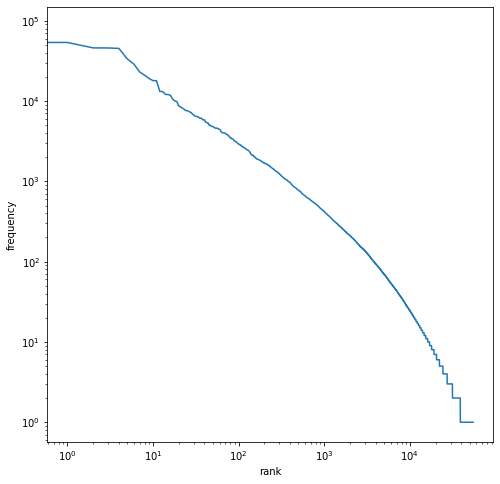

[83804, 53636, 45886, 45800, 45224, 33558, 28783, 22990, 20953, 19124, 17954, 17932, 13197, 13099, 12096, 12044, 11789, 10576, 10021, 9835, 8708, 8423, 8199, 7934, 7631, 7580, 7476, 7295, 7179, 6849, 6680, 6494, 6452, 6366, 6320, 6120, 6098, 6094, 5839, 5839, 5817, 5478, 5445, 5343, 5338, 5048, 5043, 4904, 4901, 4825, 4818, 4742, 4698, 4606, 4599, 4596, 4593, 4551, 4536, 4449, 4424, 4400, 4224, 4105, 4044, 4042, 4018, 4016, 4016, 4013, 3966, 3927, 3849, 3847, 3833, 3767, 3703, 3694, 3595, 3558, 3466, 3466, 3465, 3386, 3379, 3376, 3368, 3332, 3235, 3204, 3158, 3150, 3145, 3112, 3082, 3075, 3034, 3008, 2943, 2941, 2915, 2898, 2878, 2868, 2862, 2812, 2801, 2796, 2792, 2736, 2713, 2701, 2679, 2676, 2672, 2640, 2638, 2609, 2606, 2586, 2581, 2549, 2531, 2497, 2497, 2480, 2469, 2453, 2444, 2440, 2425, 2413, 2394, 2376, 2336, 2314, 2276, 2271, 2252, 2197, 2169, 2146, 2128, 2127, 2126, 2119, 2117, 2112, 2102, 2097, 2058, 2048, 2042, 2034, 2004, 2000, 1999, 1977, 1970, 1943, 1938, 1934, 1920, 19

In [20]:
plt.figure(figsize=(8, 8)) 
plt.plot([f[1] for f in sorted_freqs])
plt.xscale('log') 
plt.yscale('log') 
plt.xlabel('rank') 
plt.ylabel('frequency')
plt.show()
print([f[1] for f in sorted_freqs])

# Zad 7
 Install Morfeusz (Binding dla Pythona) and use it to find all words that do not appear in that dictionary.

In [21]:
import morfeusz2 
morf = morfeusz2.Morfeusz()

In [22]:
print(morfeusz2.__version__)

1.99.0


In [23]:
morf.analyse("ustawa")

[(0, 1, ('ustawa', 'ustawa', 'subst:sg:nom:f', ['nazwa_pospolita'], []))]

In [24]:
morf.analyse("klfjakdhhjsf")

[(0, 1, ('klfjakdhhjsf', 'klfjakdhhjsf', 'ign', [], []))]

In [25]:
def is_in_morfeusz(word): 
    return morf.analyse(word)[0][2][2] != 'ign' 

In [26]:
words_not_in_morfeusz = [word for word in sorted_freqs if not is_in_morfeusz(word[0])]

In [27]:
words_not_in_morfeusz

[('poz', 45224),
 ('późn', 1065),
 ('str', 516),
 ('gmo', 298),
 ('sww', 216),
 ('operacyjno', 209),
 ('skw', 196),
 ('rolno', 194),
 ('ike', 162),
 ('społeczno', 137),
 ('techniczno', 125),
 ('remediacji', 120),
 ('ure', 103),
 ('rozdz', 102),
 ('uke', 97),
 ('itp', 96),
 ('sanitarno', 88),
 ('charytatywno', 87),
 ('pkwiu', 81),
 ('udt', 77),
 ('bswsg', 70),
 ('bswp', 66),
 ('biobójczych', 63),
 ('organizacyjno', 58),
 ('phs', 53),
 ('komandytowo', 51),
 ('wodociągowo', 47),
 ('architektoniczno', 44),
 ('hcfc', 44),
 ('emerytalno', 42),
 ('adopcyjno', 42),
 ('fep', 42),
 ('dyplomatyczno', 41),
 ('mgo', 41),
 ('utk', 40),
 ('frd', 36),
 ('ron', 35),
 ('uokik', 35),
 ('doke', 34),
 ('cbśp', 34),
 ('pcn', 32),
 ('vitro', 32),
 ('haccp', 32),
 ('iia', 31),
 ('its', 31),
 ('kontrolno', 30),
 ('metylo', 30),
 ('inulinowego', 29),
 ('efrrow', 28),
 ('fenylo', 28),
 ('diagnostyczno', 27),
 ('pcb', 26),
 ('ureaformu', 26),
 ('plk', 26),
 ('biuretu', 25),
 ('szkolno', 24),
 ('tdt', 24),
 ('ych'

# Zad 8
Find 30 words with the highest ranks that do not belong to the dictionary.

In [28]:
words_not_in_morfeusz[:30]

[('poz', 45224),
 ('późn', 1065),
 ('str', 516),
 ('gmo', 298),
 ('sww', 216),
 ('operacyjno', 209),
 ('skw', 196),
 ('rolno', 194),
 ('ike', 162),
 ('społeczno', 137),
 ('techniczno', 125),
 ('remediacji', 120),
 ('ure', 103),
 ('rozdz', 102),
 ('uke', 97),
 ('itp', 96),
 ('sanitarno', 88),
 ('charytatywno', 87),
 ('pkwiu', 81),
 ('udt', 77),
 ('bswsg', 70),
 ('bswp', 66),
 ('biobójczych', 63),
 ('organizacyjno', 58),
 ('phs', 53),
 ('komandytowo', 51),
 ('wodociągowo', 47),
 ('architektoniczno', 44),
 ('hcfc', 44),
 ('emerytalno', 42)]

# Zad 9
Find 30 random words (i.e. shuffle the words) with 5 occurrences that do not belong to the dictionary.

In [29]:
from random import shuffle
words_5_occurences=list(filter(lambda x: x[1]==5, words_not_in_morfeusz))
shuffle(words_5_occurences)

words_5_occurences[:30]

[('betezda', 5),
 ('wlkp', 5),
 ('geodezyjno', 5),
 ('zawart', 5),
 ('organicz', 5),
 ('próbobiorców', 5),
 ('rialnego', 5),
 ('inci', 5),
 ('jed', 5),
 ('ośc', 5),
 ('chelatującym', 5),
 ('denitracyjne', 5),
 ('vista', 5),
 ('ami', 5),
 ('rci', 5),
 ('shigella', 5),
 ('wapnio', 5),
 ('winopochodne', 5),
 ('heptanol', 5),
 ('kpwig', 5),
 ('cznika', 5),
 ('tzn', 5),
 ('difenylopropylo', 5),
 ('edukacyjno', 5),
 ('regazyfikacyjnego', 5),
 ('schetyna', 5),
 ('swine', 5),
 ('najmnie', 5),
 ('teryto', 5),
 ('nym', 5)]

# Zad 10
Use Levenshtein distance and the frequency list, to determine the most probable correction of the words from lists defined in points 8 and 9. (Note: You don't have to apply the distance directly. Any method that is more efficient than scanning the dictionary will be appreciated.)

In [30]:
WORDS = Counter({key:val for key, val in filtered_aggr.items() if is_in_morfeusz(key)})
WORDS

Counter({'ustawa': 3235,
         'dnia': 17954,
         'grudnia': 2117,
         'zmianie': 1518,
         'ustawy': 13099,
         'podatku': 2048,
         'towarów': 1920,
         'usług': 1629,
         'oraz': 33558,
         'akcyzowym': 90,
         'art': 83804,
         'ustawie': 5478,
         'stycznia': 1894,
         'wprowadza': 1999,
         'się': 45886,
         'następujące': 2276,
         'zmiany': 4016,
         'dotychczasowa': 50,
         'treść': 486,
         'otrzymuje': 9835,
         'oznaczenie': 556,
         'ust': 53636,
         'dodaje': 8423,
         'brzmieniu': 7295,
         'rada': 2000,
         'ministrów': 2425,
         'może': 12096,
         'określać': 357,
         'drodze': 7179,
         'rozporządzenia': 5338,
         'towary': 589,
         'usługi': 1007,
         'wyjątkiem': 1670,
         'wyrobów': 1470,
         'akcyzowych': 481,
         'metali': 89,
         'szlachetnych': 33,
         'których': 17932,
         'n

In [31]:
# Code from https://norvig.com/spell-correct.html

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'aąbcćdeęfghijklłmnoópqrstuvwxyzżź'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [32]:
print(edits1('ala'))

{'afla', 'aala', 'vla', 'alpa', 'ama', 'tala', 'ara', 'tla', 'aila', 'alad', 'alal', 'alae', 'oala', 'aua', 'aźa', 'alc', 'ćla', 'aca', 'alm', 'vala', 'alr', 'awla', 'aęa', 'alac', 'dla', 'xla', 'alża', 'alay', 'aża', 'óala', 'alaż', 'ald', 'als', 'kla', 'alaę', 'alna', 'aia', 'ahla', 'alea', 'ęla', 'ata', 'alł', 'aja', 'ana', 'fla', 'alw', 'alt', 'hala', 'alag', 'axa', 'alż', 'ąla', 'aka', 'alz', 'ąala', 'alan', 'aula', 'alwa', 'sala', 'wla', 'alma', 'alća', 'alfa', 'cala', 'mala', 'alóa', 'iala', 'pala', 'alę', 'bla', 'alx', 'rala', 'anla', 'alta', 'nala', 'aóa', 'ażla', 'alqa', 'aya', 'aba', 'alaq', 'alaą', 'ula', 'alua', 'adla', 'alia', 'dala', 'abla', 'aza', 'aęla', 'alao', 'alj', 'ajla', 'aa', 'alp', 'alź', 'alat', 'alau', 'óla', 'alaó', 'alaw', 'alaz', 'ayla', 'akla', 'qla', 'alba', 'alza', 'avla', 'aqla', 'aola', 'alja', 'ćala', 'la', 'alaź', 'wala', 'yala', 'alga', 'aly', 'alq', 'alas', 'lala', 'żla', 'alav', 'apla', 'ela', 'laa', 'żala', 'jla', 'aąla', 'aela', 'aloa', 'bala',

## List from zad8

In [33]:

pprint.pprint([(word, correction(word))for word, _ in words_not_in_morfeusz[:30]])

[('poz', 'pod'),
 ('późn', 'plan'),
 ('str', 'sar'),
 ('gmo', 'imo'),
 ('sww', 'swe'),
 ('operacyjno', 'operacyjne'),
 ('skw', 'sów'),
 ('rolno', 'rolne'),
 ('ike', 'ile'),
 ('społeczno', 'społeczne'),
 ('techniczno', 'techniczne'),
 ('remediacji', 'mediacji'),
 ('ure', 'urz'),
 ('rozdz', 'rozkaz'),
 ('uke', 'ust'),
 ('itp', 'atp'),
 ('sanitarno', 'sanitarny'),
 ('charytatywno', 'charytatywną'),
 ('pkwiu', 'kwitu'),
 ('udt', 'ust'),
 ('bswsg', 'bswsg'),
 ('bswp', 'bhp'),
 ('biobójczych', 'biobójczych'),
 ('organizacyjno', 'organizacyjne'),
 ('phs', 'prs'),
 ('komandytowo', 'komandytowa'),
 ('wodociągowo', 'wodociągowe'),
 ('architektoniczno', 'architektoniczne'),
 ('hcfc', 'cfc'),
 ('emerytalno', 'emerytalne')]


## List from zad9

In [34]:
start_time=time.time()
corrections=[(word, correction(word))for word, _ in words_5_occurences[:30]]
pprint.pprint(corrections)
print(time.time() - start_time)


[('betezda', 'betezda'),
 ('wlkp', 'pkp'),
 ('geodezyjno', 'geodezyjne'),
 ('zawart', 'zawarte'),
 ('organicz', 'organach'),
 ('próbobiorców', 'próbobiorców'),
 ('rialnego', 'realnego'),
 ('inci', 'inni'),
 ('jed', 'jej'),
 ('ośc', 'ości'),
 ('chelatującym', 'chelatującym'),
 ('denitracyjne', 'denitracyjne'),
 ('vista', 'lista'),
 ('ami', 'ani'),
 ('rci', 'rui'),
 ('shigella', 'shigella'),
 ('wapnio', 'wapnia'),
 ('winopochodne', 'winopochodne'),
 ('heptanol', 'metanol'),
 ('kpwig', 'krwi'),
 ('cznika', 'ocznika'),
 ('tzn', 'ten'),
 ('difenylopropylo', 'difenylopropylo'),
 ('edukacyjno', 'edukacyjne'),
 ('regazyfikacyjnego', 'regazyfikacyjnego'),
 ('schetyna', 'schetyna'),
 ('swine', 'swoje'),
 ('najmnie', 'najmniej'),
 ('teryto', 'tery'),
 ('nym', 'tym')]
2.463282346725464


# Zad11
Load SGJP dictionary (Słownik SGJP dane tekstowe) to ElasticSearch (one document for each form) and use fuzzy matching to obtain the possible corrections of the 30 words with 5 occurrences that do not belong to the dictionary.

In [35]:
import csv 
 
sgjp_words = set() 
with open("sgjp-20211107.tab") as tsv: 
    i = 0 
    for line in csv.reader(tsv, dialect="excel-tab"): 
        if i < 28:
            i+=1
        else:
            sgjp_words.add(line[0].lower()) 

In [36]:
print(len(sgjp_words))

4908949


In [37]:
client = Elasticsearch([{'host':'elastic'}])
elasticsearch_dsl.connections.add_connection('python_client', client) 


In [38]:
client.info()

{'name': '2a66b4d92441',
 'cluster_name': 'docker-cluster',
 'cluster_uuid': 'fBLFGyh0QV-laWI0El2OWg',
 'version': {'number': '7.10.1',
  'build_flavor': 'default',
  'build_type': 'docker',
  'build_hash': '1c34507e66d7db1211f66f3513706fdf548736aa',
  'build_date': '2020-12-05T01:00:33.671820Z',
  'build_snapshot': False,
  'lucene_version': '8.7.0',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}

In [39]:
analyzer = elasticsearch_dsl.analyzer( 
    'keyword_analyzer', 
    type='custom', 
    tokenizer='keyword' 
)

In [40]:
class WordDocument(Document): 
    word = Text(analyzer=analyzer) 
 
    class Index: 
        name = 'sgjp' 

In [41]:
if WordDocument._index.exists(using=client):
    WordDocument._index.delete(using=client)
WordDocument.init(using=client)
start_time = time.time()
loaded_records, _ = helpers.bulk(client, [WordDocument(word=w).to_dict(True) for w in sgjp_words])

print(time.time() - start_time)
print(loaded_records)

318.4312584400177
4908949


In [42]:
start_time = time.time()
elastic_corrections = []
for word, _ in words_5_occurences[:30]:
    s = Search(using=client, index='sgjp') \
        .query(Q({'fuzzy': {
        'word': {
            'value': word,
            'fuzziness': 5
        }
        
    }}))
    results = s.execute()
    if len(results) == 0:
        elastic_corrections.append((word, word))    
    else:
        elastic_corrections.append((word, [r.word for r in results]))
    
elastic_time = time.time()-start_time
print('\ntime', elastic_time)


time 2.177469253540039


In [43]:
pprint.pprint(elastic_corrections)

[('betezda', ['berenda', 'berezka', 'bereza', 'etezja', 'bereda']),
 ('wlkp',
  ['wlep',
   'wlk',
   'olku',
   'klup',
   'elkę',
   'waki',
   'klip',
   'elką',
   'flop',
   'ulep']),
 ('geodezyjno',
  ['geodezyjno',
   'geodezyjne',
   'geodezyjną',
   'geodezyjna',
   'geodezyjny',
   'geodezyjni',
   'geodezyjność',
   'geodezyjnym',
   'geodezyjnie',
   'geodezyjnego']),
 ('zawart',
  ['zawarz',
   'zapart',
   'zawarta',
   'zawarż',
   'zawarł',
   'zawarć',
   'zawartą',
   'gawart',
   'zawarty',
   'zawarto']),
 ('organicz',
  ['ogranicz',
   'organicy',
   'organiczno',
   'organiczna',
   'organiczną',
   'organiczni',
   'ograniczą',
   'organika',
   'organiki',
   'organizm']),
 ('próbobiorców', ['prądobiorców', 'pracobiorców']),
 ('rialnego',
  ['realnego',
   'upalnego',
   'sielnego',
   'ciasnego',
   'witalnego',
   'finalnego',
   'mialonego',
   'piasnego',
   'rżawnego',
   'atrialnego']),
 ('inci',
  ['inki',
   'irci',
   'ince',
   'vinci',
   'inni',
   '

# Zad12
Compare the results of your algorithm and output of ES

In [44]:
contains=0
for ((word, cwords), (_, e_cwords)) in zip(corrections, elastic_corrections):
    print(f'{word}: \n Levenshein : {cwords} \n Elasticsearch : {e_cwords}')
    if cwords in e_cwords:
        print("Contains \n")
        contains+=1
    else:
        print('not contains\n')

betezda: 
 Levenshein : betezda 
 Elasticsearch : ['berenda', 'berezka', 'bereza', 'etezja', 'bereda']
not contains

wlkp: 
 Levenshein : pkp 
 Elasticsearch : ['wlep', 'wlk', 'olku', 'klup', 'elkę', 'waki', 'klip', 'elką', 'flop', 'ulep']
not contains

geodezyjno: 
 Levenshein : geodezyjne 
 Elasticsearch : ['geodezyjno', 'geodezyjne', 'geodezyjną', 'geodezyjna', 'geodezyjny', 'geodezyjni', 'geodezyjność', 'geodezyjnym', 'geodezyjnie', 'geodezyjnego']
Contains 

zawart: 
 Levenshein : zawarte 
 Elasticsearch : ['zawarz', 'zapart', 'zawarta', 'zawarż', 'zawarł', 'zawarć', 'zawartą', 'gawart', 'zawarty', 'zawarto']
not contains

organicz: 
 Levenshein : organach 
 Elasticsearch : ['ogranicz', 'organicy', 'organiczno', 'organiczna', 'organiczną', 'organiczni', 'ograniczą', 'organika', 'organiki', 'organizm']
not contains

próbobiorców: 
 Levenshein : próbobiorców 
 Elasticsearch : ['prądobiorców', 'pracobiorców']
not contains

rialnego: 
 Levenshein : realnego 
 Elasticsearch : ['realneg

In [45]:
print(contains, len(corrections))

15 30


# Zad13
Draw conclusions regarding: 

- the distribution of words in the corpus,

The most popular words are punctation marks and conjunctions like `,`, `.`, `i` etc. Other than that words connotated directly to the law (like `art`). We can see that the number of words is quite constant in the highest range - later there is the quick drop. 

- the number of true misspellings vs. the number of unknown words,

The most unknown words are not misspellings, but shortened forms of some expressions (like `ike`, `bswp`)

- the performance of your method compared to ElasticSearch,

The ElasticSearch is faster and gives more options, however the time for loading dictionary to elasticsearch is 2 orders of magnitude greater than levensthein. This means that if we want to do more operations on one dictionary, elasticsearch is better.

- the results provided by your method compared to ElasticSearch,

Elasticsearch gives more options and gives more fuzziness in less time

- the validity of the obtained corrections.

Corrections seem reasonable - especially from the elasticsearch